C:\Users\marks\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
INFO:root:Starting training...


Epoch 1/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9660 - loss: 0.2545 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 2/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8816 - loss: 0.3548 - val_accuracy: 1.0000 - val_loss: 0.3737
Epoch 3/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6092 - loss: 0.6639 - val_accuracy: 0.7563 - val_loss: 0.5702
Epoch 4/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6546 - loss: 0.6334 - val_accuracy: 0.7484 - val_loss: 0.5720
Epoch 5/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7837 - loss: 0.4610 - val_accuracy: 0.5750 - val_loss: 0.8183
Epoch 6/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8090 - loss: 0.4344 - val_accuracy: 0.5453 - val_loss: 0.9707
Epoch 7/7
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8155 - loss: 0.4288 - val_accuracy: 0.6938 - val_loss: 0.7412


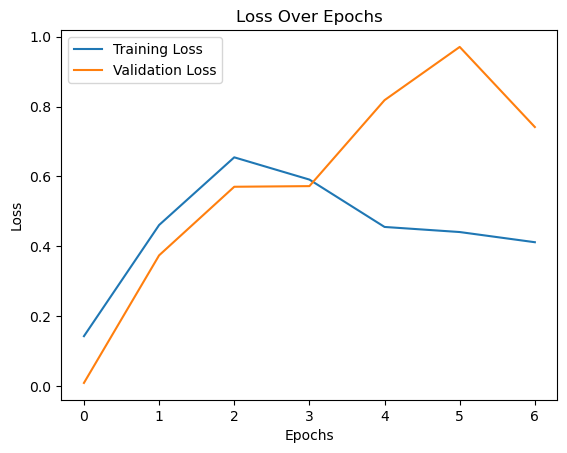

INFO:root:Evaluating model...
C:\Users\marks\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marks\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marks\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
INFO:root:Precision: 0.0, Recall: 0.0, F1 Score: 0.0


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\marks\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


ValueError: not enough values to unpack (expected 2, got 0)

In [8]:
import os
import tensorflow as tf
import re
import string
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Set up logging
logging.basicConfig(level=logging.INFO)

# Directories for positive and negative text files
train_positive_dir = 'OneDrive/Dokumente/UH/Fall 24/ICS 661 AI/Assignment 2/train/pos/'
train_negative_dir = 'OneDrive/Dokumente/UH/Fall 24/ICS 661 AI/Assignment 2/train/neg/'
val_positive_dir = 'OneDrive/Dokumente/UH/Fall 24/ICS 661 AI/Assignment 2/test/pos/'
val_negative_dir = 'OneDrive/Dokumente/UH/Fall 24/ICS 661 AI/Assignment 2/test/neg/'

# Text cleaning function using TensorFlow string ops
def clean_text(text):
    text = tf.strings.lower(text)  # Lowercase
    text = tf.strings.regex_replace(text, r'<.*?>', '')  # Remove HTML tags
    text = tf.strings.regex_replace(text, r'\d+', '')  # Remove numbers
    text = tf.strings.regex_replace(text, f"[{string.punctuation}]", '')  # Remove punctuation
    return text

# Load and clean data from directory
def load_data_from_directory(directory, label):
    file_paths = [os.path.join(directory, f) for f in os.listdir(directory)]
    for path in file_paths:
        with open(path, 'r', encoding='utf-8', errors='ignore') as file:
            text = file.read()
            yield text, label

# Tokenizer for preprocessing
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=100000)

# Create tf.data.Dataset from the directory
def create_dataset(positive_dir, negative_dir, batch_size):
    pos_gen = load_data_from_directory(positive_dir, 1)
    neg_gen = load_data_from_directory(negative_dir, 0)

    def generator():
        yield from pos_gen
        yield from neg_gen

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

    dataset = dataset.shuffle(10000).batch(batch_size).repeat()

    # Apply the clean_text function using TensorFlow's map
    dataset = dataset.map(lambda text, label: (clean_text(text), label))

    # Tokenize and pad the dataset using TensorFlow's py_function
    def tokenize_and_pad(text_batch, label_batch):
        # Convert TensorFlow strings to Python strings
        text_batch = [text.numpy().decode('utf-8') for text in text_batch]
        
        # Tokenize and pad
        sequences = tokenizer.texts_to_sequences(text_batch)
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=100)
        return padded_sequences, label_batch

    # Use tf.py_function to apply Python logic inside a TensorFlow graph pipeline
    dataset = dataset.map(lambda text, label: tf.py_function(func=tokenize_and_pad, inp=[text, label], 
                                                             Tout=(tf.int32, tf.int32)))

    # Set the shape of the dataset
    dataset = dataset.map(lambda text, label: (tf.ensure_shape(text, [None, 100]), tf.ensure_shape(label, [None])))

    return dataset

# Define and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=100000, output_dim=64, input_length=100),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare dataset
batch_size = 32

# Fit tokenizer on the entire dataset
all_texts = [text for text, _ in load_data_from_directory(train_positive_dir, 1)] + \
            [text for text, _ in load_data_from_directory(train_negative_dir, 0)]
all_texts = [clean_text(tf.constant(t)).numpy().decode('utf-8') for t in all_texts]  # Clean before tokenizing
tokenizer.fit_on_texts(all_texts)

# Create datasets
train_dataset = create_dataset(train_positive_dir, train_negative_dir, batch_size)
val_dataset = create_dataset(val_positive_dir, val_negative_dir, batch_size)

# Train the model and capture the history
logging.info("Starting training...")
history = model.fit(train_dataset, epochs=7, steps_per_epoch=100, validation_data=val_dataset, validation_steps=20)

# Plot the loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model - this time calculating additional metrics
logging.info("Evaluating model...")

# Get predictions from the model
y_true = []
y_pred = []

for text_batch, label_batch in val_dataset.take(20):  # Evaluate on 20 steps of validation dataset
    preds = model.predict(text_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend((preds > 0.5).astype(int))  # Convert probabilities to binary predictions

# Calculate Precision, Recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

logging.info(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

# Also evaluate using built-in Keras metrics
loss, accuracy = model.evaluate(val_dataset, steps=20)
logging.info(f"Validation loss: {loss}, Validation accuracy: {accuracy}")

In [7]:
print(train_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(None, 100), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
